In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.model_selection import train_test_split, GroupKFold
import lightgbm as lgbm
import joblib

In [2]:
cfg = {'model_path': 'lgb.pkl',
      'save_model': True,
      'pretrained': False}

In [3]:
data_path = 'instacart-market-basket-analysis/'

In [4]:
departments = pd.read_csv(data_path + 'departments.csv')
prior = pd.read_csv(data_path + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
train = pd.read_csv(data_path + 'order_products__train.csv')
orders = pd.read_csv(data_path + 'orders.csv')
products = pd.read_csv(data_path + 'products.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Goal:
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order

-Table: orders
    +order_id: id of order (PK)
    +user_id: id of user
    +eval_set: Type of customer (prior, train, test)
        In this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. 
        ->So the last order of the user has been taken out and divided into train and test sets

        ++prior: prior orders dataset  
        ++train: train dataset of the last order
        ++test: test dataset of the last order

    +order_number: number of order
    +order_dow: order in day of week(from 0 -> 6) <But we don't know which values represent which day
    +order_hour_of_day: order in  hour of a day (0->23) 
    +days_since_prior_order: Day that people buy again

-Table: order_products__train: information about train order
    +order_id: id of order
    +product_id: id of product
    +PK: order_id + product_id
    +add_to_cart_order: number of product of that order that people add to cart(buy)
    +reordered: Is that order 

-Table: order_product_prior: information about prior order

-Table: product: product information
    product_id(PK)
    product_name
    aisle_id
    department_id

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_trainX, oversampled_trainY = sm.fit_resample(train[['order_id', 'product_id', 'add_to_cart_order']], train.reordered)

In [11]:
train = pd.concat([oversampled_trainX, oversampled_trainY], axis=1)

In [19]:
train.sort_index()

order_id  product_id  add_to_cart_order  reordered
order_id product_id                                                    
1        10246              1       10246                  3          0
         11109              1       11109                  2          1
         13176              1       13176                  6          0
         22035              1       22035                  8          1
         43633              1       43633                  5          1
...                       ...         ...                ...        ...
3421063  35548        3421063       35548                  4          1
         49235        3421063       49235                  1          1
3421070  4724         3421070        4724                  3          1
         16953        3421070       16953                  2          1
         35951        3421070       35951                  1          1

[1657648 rows x 4 columns]

In [12]:
print('computing product f')
prods = pd.DataFrame()
prods['orders'] = prior.groupby(prior.product_id).size().astype(np.int32)
prods['reorders'] = prior['reordered'].groupby(prior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

print('add order info to prior')
#orders.set_index('order_id', inplace=True, drop=False)
prior = prior.join(orders, on='order_id', rsuffix='_')
prior.drop('order_id_', inplace=True, axis=1)

### user features

print('computing user f')
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = prior.groupby('user_id').size().astype(np.int16)
users['all_products'] = prior.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('user f', users.shape)

computing product f
add order info to prior
computing user f
user f (206208, 6)


In [13]:
products

,product_id,product_name,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,,
1,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
2,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
3,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
4,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
5,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000
...,...,...,...,...,...,...,...
49684,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,9.0,1.0,0.111111
49685,49685,En Croute Roast Hazelnut Cranberry,42,1,49.0,6.0,0.122449
49686,49686,Artisan Baguette,112,3,120.0,84.0,0.700000


In [14]:
prior

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,1.0,prior,3.0,3.0,12.0,21.0
1,2,28985,2,1,1.0,prior,3.0,3.0,12.0,21.0
2,2,9327,3,0,1.0,prior,3.0,3.0,12.0,21.0
3,2,45918,4,1,1.0,prior,3.0,3.0,12.0,21.0
4,2,30035,5,0,1.0,prior,3.0,3.0,12.0,21.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,NaN,NaN,NaN,NaN,NaN,NaN
32434485,3421083,11352,7,0,NaN,NaN,NaN,NaN,NaN,NaN
32434486,3421083,4600,8,0,NaN,NaN,NaN,NaN,NaN,NaN
32434487,3421083,24852,9,1,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
users

,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1.0,92,"{15873, 29193, 40462, 27156, 6184, 34862, 1746...",91,19.000000,11,8.363636
2.0,141,"{20995, 45066, 26648, 9755, 34335, 1057, 31268...",137,16.285715,15,9.400000
3.0,95,"{19970, 10243, 49156, 20995, 47626, 26128, 496...",90,12.000000,13,7.307693
4.0,31,"{13966, 21903, 31509, 48679, 28204, 33198, 198...",31,17.000000,6,5.166667
5.0,38,"{41602, 15364, 27656, 17417, 22282, 11403, 368...",38,11.500000,5,7.600000
...,...,...,...,...,...,...
206205.0,70,"{256, 11009, 38400, 10499, 20995, 18435, 39428...",68,16.666666,4,17.500000
206206.0,651,"{30720, 8193, 18441, 45066, 49176, 20507, 2078...",533,3.716418,68,9.573529
206207.0,158,"{8193, 20995, 11782, 47626, 26131, 49683, 4508...",148,14.312500,17,9.294118


In [16]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [17]:
### userXproduct features

print('compute userXproduct f - this is long...')
prior['user_product'] = prior.product_id + prior.user_id * 100000

# This was to slow !!
#def last_order(order_group):
#    ix = order_group.order_number.idxmax
#    return order_group.shape[0], order_group.order_id[ix],  order_group.add_to_cart_order.mean()
#userXproduct = pd.DataFrame()
#userXproduct['tmp'] = df.groupby('user_product').apply(last_order)

d= dict()
for row in prior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del prior

### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    # df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    # df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)
    

df_train, labels = features(train_orders, labels_given=True)

compute userXproduct f - this is long...
to dataframe (less memory)
user X product f 29302795
split orders : train, test
build candidate list


C:\Users\Acer\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:2944: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


KeyboardInterrupt: 

In [ ]:
userXproduct

In [ ]:
df_train

In [ ]:
plt.hist(labels)

In [ ]:
labels

In [ ]:
df_test, _ = features(test_orders)

In [ ]:
df_test

# Splitting data and training

### Features

In [ ]:
feat = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', #'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last']

### Train-val split

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train[feat], labels, test_size=0.3, stratify=labels)

### Deal with imbalance data

In [ ]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy='minority', random_state=42)
# oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)

### Load model

In [ ]:
if cfg['pretrained'] == True:
    model = joblib.load(cfg['model_path'])
    print("Loaded model")
else:
    model = lgbm.LGBMClassifier(metric = "auc")

### Training

In [ ]:
# reordered_index = np.array([i for i in range(len(labels)) if labels[i] == 1])

# for i in range(len(df_train)//len(reordered_index)):
#     print('Training fold %d \n' % i)
#     if ((i + 1) * len(reordered_index) >= len(df_train)):
#         X_train = pd.concat([df_train[feat].iloc[:-len(reordered_index)], df_train[feat].iloc[reordered_index]])
#         y_train = np.concatenate((labels[:-len(reordered_index)], reordered_index))
#     else:
#         X_train = pd.concat([df_train[feat].iloc[i * len(reordered_index): (i + 1) * len(reordered_index)], \
#                              df_train[feat].iloc[reordered_index]])
#         y_train = np.concatenate((labels[i * len(reordered_index): (i + 1) * len(reordered_index)], reordered_index))
#     model.fit(X_train, y_train)
#     print(model.score(X_test, y_test))

In [ ]:
model.fit(X_train, y_train,
         eval_set = (X_test, y_test))

In [ ]:
if cfg['save_model'] == True:
    # save model
    joblib.dump(model, 'auc_lgb.pkl')
    print("Saved model")

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

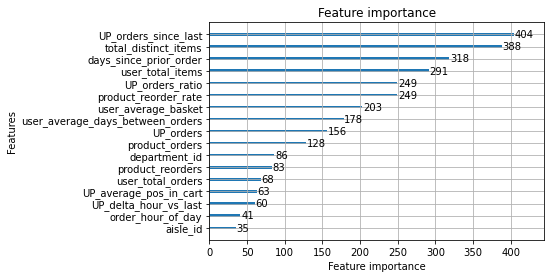

In [81]:
lgbm.plot_importance(model)

## Validation

In [82]:
from sklearn.metrics import classification_report

y_hat = model.predict(X_test)
print("Test Dataset")
print(classification_report(y_test, y_hat))


predictions_train = model.predict(X_train)
print("Train Dataset")
print(classification_report(y_train, predictions_train))

predictions_oversample_train = model.predict(oversampled_trainX)
print("Oversample Train Dataset")
print(classification_report(oversampled_trainY, predictions_oversample_train))

Test Dataset
              precision    recall  f1-score   support

           0       0.92      0.99      0.95   2293752
           1       0.64      0.17      0.27    248647

    accuracy                           0.91   2542399
   macro avg       0.78      0.58      0.61   2542399
weighted avg       0.89      0.91      0.89   2542399

Train Dataset
              precision    recall  f1-score   support

           0       0.92      0.99      0.95   5352085
           1       0.64      0.17      0.27    580177

    accuracy                           0.91   5932262
   macro avg       0.78      0.58      0.61   5932262
weighted avg       0.89      0.91      0.89   5932262



NameError: name 'oversampled_trainX' is not defined

Normalized confusion matrix
[[0.9893563  0.0106437 ]
 [0.82726114 0.17273886]]


<Figure size 864x864 with 0 Axes>

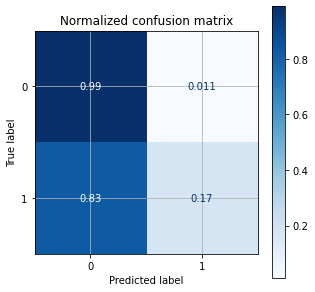

In [83]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(12,12))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize="true")
disp.ax_.set_title("Normalized confusion matrix")

print("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

# Making predictions


In [82]:
preds = model.predict(df_test[feat])
df_test['preds'] = preds

In [83]:
df_test

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,aisle_id,...,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,preds
0,2774568,17668,13,88,33,12.000000,6.769231,15,11.0,91,...,2110,1220.0,0.578199,5,0.384615,3.600000,0.384615,2,3,1
1,2774568,44683,13,88,33,12.000000,6.769231,15,11.0,83,...,22275,11981.0,0.537868,2,0.153846,9.500000,0.153846,7,1,0
2,2774568,48523,13,88,33,12.000000,6.769231,15,11.0,37,...,5129,2376.0,0.463248,2,0.153846,6.500000,0.153846,4,1,0
3,2774568,21903,13,88,33,12.000000,6.769231,15,11.0,123,...,241921,186884.0,0.772500,8,0.615385,4.250000,0.615385,1,0,1
4,2774568,14992,13,88,33,12.000000,6.769231,15,11.0,83,...,29069,16942.0,0.582820,2,0.153846,7.000000,0.153846,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,803273,44532,50,677,198,7.367347,13.540000,11,4.0,3,...,311,124.0,0.398714,1,0.020000,11.000000,0.020000,7,3,0
4833288,803273,46069,50,677,198,7.367347,13.540000,11,4.0,123,...,9240,5420.0,0.586580,7,0.140000,5.571429,0.140000,4,1,0
4833289,803273,12791,50,677,198,7.367347,13.540000,11,4.0,3,...,1393,755.0,0.541996,1,0.020000,12.000000,0.020000,7,3,0
4833290,803273,14332,50,677,198,7.367347,13.540000,11,4.0,72,...,6046,1424.0,0.235528,1,0.020000,9.000000,0.020000,8,8,0


In [84]:
def convert(df):
    order_id_list = df.order_id.unique()
    map_order_id_products = {}
    for i, row in df.iterrows():
        if not (row.order_id in map_order_id_products):
                map_order_id_products[row.order_id] = ""
        if row.preds == 1:
            map_order_id_products[row.order_id] += " " + str(int(row.product_id))
            map_order_id_products[row.order_id] = map_order_id_products[row.order_id].lstrip()
    return map_order_id_products

In [85]:
map_order_id_products_test = convert(df_test)

In [86]:
map_order_id_products_test

{2774568.0: '17668 21903 39190 47766 18599 43961',
 329954.0: '',
 1528013.0: '21903',
 1376945.0: '28465 27959 8309',
 1356845.0: '13176',
 2161313.0: '196 10441 12427 14715 27839',
 1416320.0: '5134 21903 21137 24852 17948',
 1735923.0: '17008 15599 31487 34690',
 1980631.0: '13575 6184 9387 46061 13914 22362',
 139655.0: '17794 27845',
 1411408.0: '',
 2940603.0: '30592 19894 44632 14947 18531 31615',
 1192143.0: '24852',
 280888.0: '35413 13966 196 32566 4595',
 3202221.0: '49215 21137 43692 4793 20168 17630 24852 11130 9637 6069 39911',
 3222866.0: '37131 32912 7969 33198 8501 32441 35921 15718',
 707453.0: '45066 42585 48230 21137 47766 18150 24852 32030 44830 7969 4942 21903 6111',
 1320132.0: '22328',
 882556.0: '28289 42768 24852 25890 48679 28204 41149 5450 7371 8424 30962 9076',
 2431024.0: '22035 27555 34217 39928 6975 5699 5450 24799 29926 13176',
 2827745.0: '',
 2174416.0: '',
 1325316.0: '26165',
 320326.0: '24852 42828',
 2128599.0: '',
 1099519.0: '22035 26351 13176',

In [87]:
tmp = pd.DataFrame(map_order_id_products_test.items())

In [88]:
tmp.columns = ['order_id', 'target']
tmp.target.replace("", "None", inplace = True)

In [89]:
sub = sample_submission.merge(tmp, on = ['order_id'])
sub.drop(['products'], axis = 1, inplace = True)
sub.columns = ['order_id', 'products']

In [90]:
sub[['order_id', 'products']].to_csv('sub1.csv', index = False)